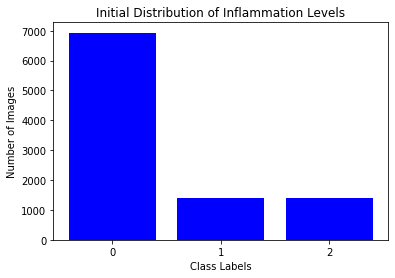

Found 1414 images belonging to 1 classes.
Found 1385 images belonging to 1 classes.


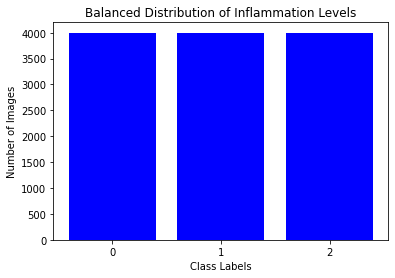

In [1]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths
data_dir = 'D:/DATASET/CNN/inflammation/train'  # Original dataset directory
balanced_data_dir = 'D:/DATASET/CNN/inflammation/balanced_train'  # Target directory for balanced dataset

# Create balanced_data directory and subdirectories for each class
os.makedirs(balanced_data_dir, exist_ok=True)
classes = ['0', '1', '2']  # Inflammation labels: 0, 1, 2
for cls in classes:
    os.makedirs(os.path.join(balanced_data_dir, cls), exist_ok=True)

def count_images_in_directory(directory):
    """ Counts the images in each subdirectory of a given directory. """
    return {folder_name: len(os.listdir(os.path.join(directory, folder_name)))
            for folder_name in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder_name))}

# Count and plot initial distribution
initial_counts = count_images_in_directory(data_dir)

def plot_distribution(data, title):
    """ Plots the distribution of data classes. """
    classes = sorted(data.keys())
    counts = [data[cls] for cls in classes]
    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

plot_distribution(initial_counts, 'Initial Distribution of Inflammation Levels')

# We want to target 4000 images for each class
target_samples = 4000

# Data augmentation setup for oversampling
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def resample_class_images(class_id, current_count):
    """ Resamples images by class: oversampling or undersampling to target_samples. """
    class_dir = os.path.join(data_dir, class_id)
    target_dir = os.path.join(balanced_data_dir, class_id)
    images = os.listdir(class_dir)

    if current_count > target_samples:  # Downsampling for class 0
        selected_images = np.random.choice(images, target_samples, replace=False)
    else:  # Oversampling for classes 1 and 2
        selected_images = images  # Include all original images
        # Augment data to reach target count
        augmentation_count = target_samples - current_count
        generator = datagen.flow_from_directory(
            directory=data_dir,
            classes=[class_id],
            target_size=(299, 299),
            batch_size=1,
            save_to_dir=target_dir,
            save_prefix='aug',
            save_format='jpeg'
        )
        for _ in range(augmentation_count):
            generator.next()

    # Copy selected images to balanced_data
    for img in selected_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(target_dir, img))

# Resample each class
for class_id in classes:
    current_count = initial_counts[class_id]
    resample_class_images(class_id, current_count)

# Count and plot balanced distribution
balanced_counts = count_images_in_directory(balanced_data_dir)
plot_distribution(balanced_counts, 'Balanced Distribution of Inflammation Levels')


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
# Initialize the base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [ ]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes for NASH scores 0, 1, 2

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# import pydot
# print(pydot.Dot.create(pydot.Dot()))

In [ ]:
# Visualize the model architecture
plot_model(model, to_file='D:/DATASET/inflammation_model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Create a model for feature map extraction
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

In [ ]:
def extract_and_display_image(image_path, feature_model):
    img = Image.open(image_path)
    img_resized = img.resize((299, 299), Image.ANTIALIAS)
    img_array = np.array(img_resized) / 255.0
    img_array = img_array[np.newaxis, ...]

    # Display the original image
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Get the feature maps
    feature_maps = feature_model.predict(img_array)[0]
    return feature_maps

In [ ]:
def visualize_feature_maps(feature_maps, num_features=15):
    # Display the first 'num_features' feature maps
    fig, axes = plt.subplots(nrows=int(np.sqrt(num_features)), ncols=int(np.sqrt(num_features)), figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_features:
            ax.imshow(feature_maps[:, :, i], cmap='viridis')
            ax.axis('off')
    plt.show()

In [ ]:
# Load images using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'D:/DATASET/CNN/inflammation/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'D:/DATASET/CNN/inflammation/val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  
)

# Save the model
model.save('D:/DATASET/Models/model_inflammation.h5')

In [ ]:
import json

# Save the training history
with open('D:/DATASET/Models/inflammation_history.json', 'w') as file:
    json.dump(history.history, file)

In [ ]:
# Function to plot validation loss
def plot_validation_loss(history, model_name):
    plt.plot(history['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Validation Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
# Plot validation loss for inflammation model
with open('D:/DATASET/Models/inflammation_history.json', 'r') as file:
    fibrosis_history = json.load(file)

plot_validation_loss(fibrosis_history, 'Inflammation')

In [ ]:
image_path = "D:/DATASET/CNN/inflammation/train/1/2_228_75.png"
feature_maps = extract_and_display_image(image_path, feature_model)
visualize_feature_maps(feature_maps)

In [ ]:
# Create a model for feature map extraction
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block1_out').output)

In [ ]:
image_path = "D:/DATASET/CNN/inflammation/train/2/168_25_37.png"
feature_maps = extract_and_display_image(image_path, feature_model)
visualize_feature_maps(feature_maps)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

def prepare_image(image_path):
    img = load_img(image_path, target_size=(299, 299))  # Ensure the image is resized
    img_array = img_to_array(img)                      # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)      # Add a dimension to fit the model input: (1, 299, 299, 3)
    img_array = preprocess_input(img_array)            # Preprocess the image as required by ResNet50
    return img_array


image_path = "D:/DATASET/CNN/inflammation/train/1/2_228_75.png"
img_array = prepare_image(image_path)

In [ ]:
for layer in model.layers:
    print(layer.name)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.cm as cm
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Use the function
# img_array should be your preprocessed image input to the model
# 'last_conv_layer' should be the name of the last convolutional layer in your model
# model is your trained model
heatmap = make_gradcam_heatmap(prepare_image('D:/DATASET/CNN/inflammation/train/1/2_228_75.png'), model, 'conv5_block3_3_conv')
plt.matshow(heatmap)
plt.show()

In [ ]:
# To use the model later without retraining:
# from tensorflow.keras.models import load_model
# model = load_model('liver_biopsy_classification_model.h5')

In [ ]:
# Improve prediction function as follows
def predict_inflammation(image_path, model):
    img = Image.open(image_path)
    img = img.resize((299, 299), Image.ANTIALIAS)  # Resize the image to match model's input
    img_array = np.array(img) / 255.0  # Rescale the image
    img_array = img_array[np.newaxis, ...]  # Add batch dimension

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    return predicted_class, confidence

In [ ]:
# Example use of the prediction function
predicted_class, confidence = predict_inflammation('D:/DATASET/CNN/inflammation/test/1/417_256_91.png', model)
print(f'Predicted class: {predicted_class} with probability: {confidence:.2f}')

In [ ]:
def crop_and_predict(image_path, model, size=(299, 299), step_size=299):
    img = Image.open(image_path)
    width, height = img.size
    scores = []

    for top in range(0, height - size[1] + 1, step_size):
        for left in range(0, width - size[0] + 1, step_size):
            # Crop the image
            crop = img.crop((left, top, left + size[0], top + size[1]))
            # Preprocess and predict
            crop_array = np.array(crop) / 255.0
            crop_array = crop_array[np.newaxis, ...]
            prediction = model.predict(crop_array)
            scores.append(np.argmax(prediction))

    # Calculate the average score
    average_score = np.mean(scores)
    return int(round(average_score))

In [ ]:
# Use this function to get an average inflammation score from a large image
average_inflammation_score = crop_and_predict("D:/Testing (Triya ma'am)/Hematoxylin eosin staining for scoring at 20X and 40x/NASH_40X/x1.jpg", model)
print(f'Average Inflammation Score: {average_inflammation_score}')